# Random walk cloaking demo

This notebook needs the module RWC.jl. This contains plotting functions, generates the graphs used, and does the simulation of the random processes.

## Random walks as solutions to the Dirichlet problem 

Consider a graph $G(V,E)$ with an edge weight $\sigma$ that is partitioned into interior nodes $I$ and boundary
nodes $\partial\Omega$. On the boundary nodes $B$ we have a Dirichlet condition $u(B)$ and an associated harmonic function
$u$. We consider random walks that are initialized on every boundary node $u(B)$ that terminate when they
return to a boundary node. Each of these random walks is tagged with a charge $C(b) = u(B)/c(b)$ where $c(b)$ is the
sum of the connected edge weights. Then the solution to the Dirichlet problem is the scaled expected total charge leaving each node 
$$u(x)= \mathbb{E}(\text{total charge departing } x)/c(x).$$

We remark that an equivalent formulation is to use random walks that begin at the interior nodes and recording the value of the boundary nodes where they terminated. While this formulation is more familiar, it is not as easily amenable to cloaking problems. Below we present an example demonstrating the equivalence between the random walk process and the solution to the Dirichlet problem.

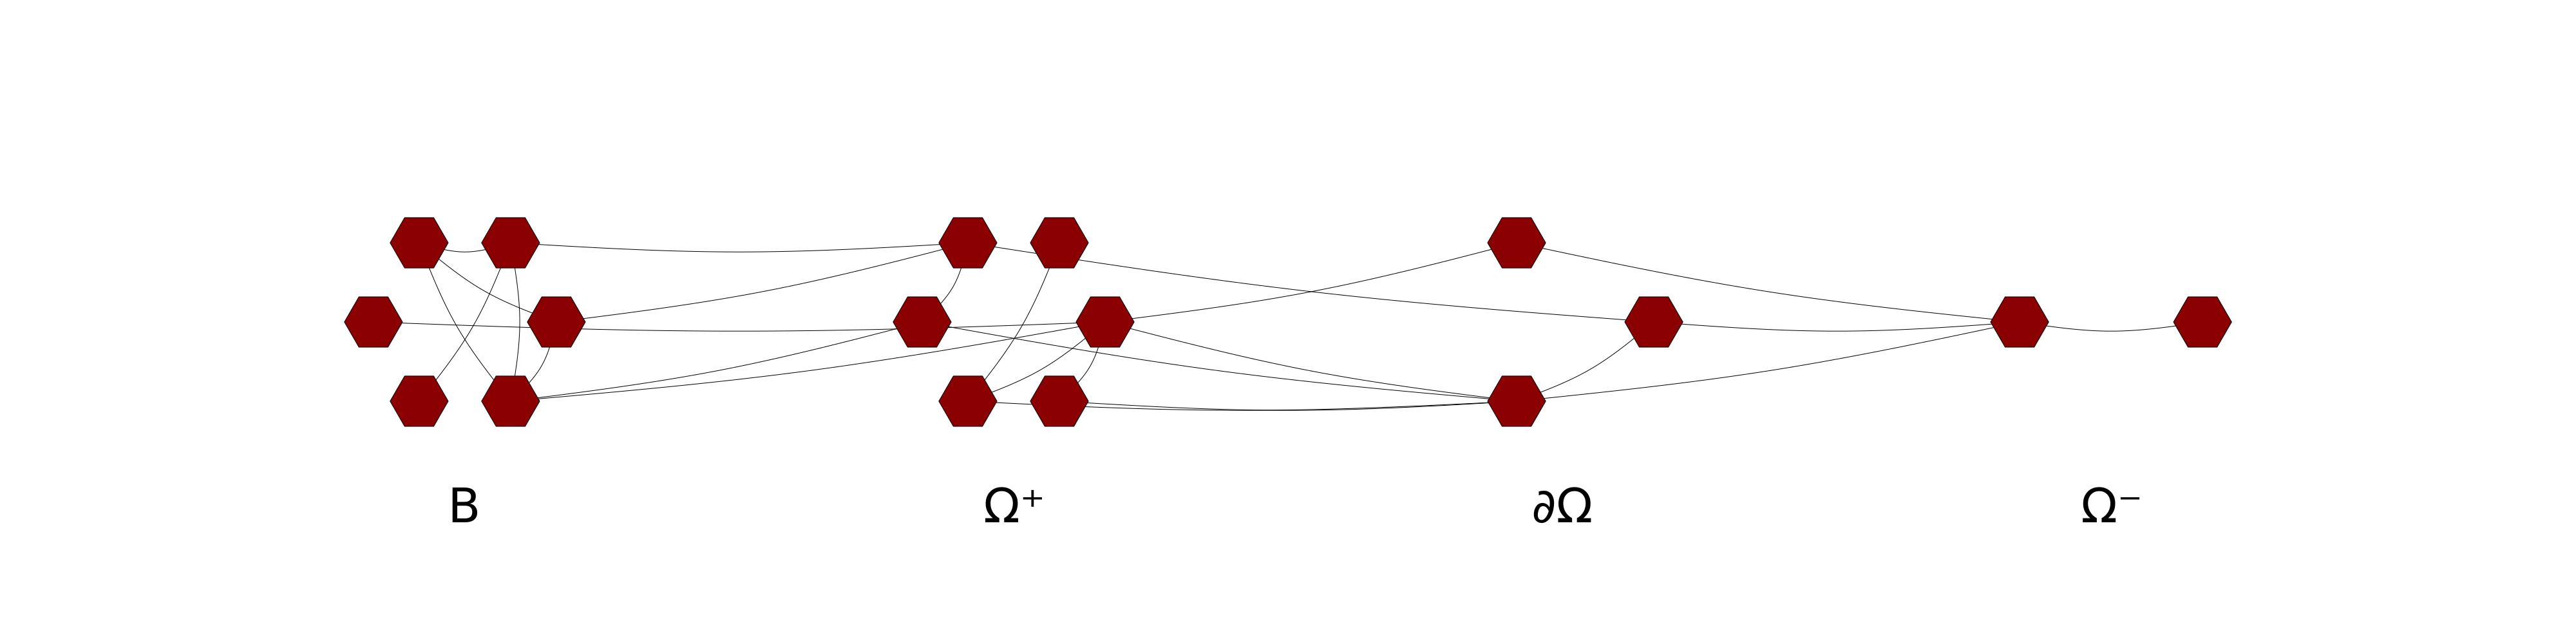

In [29]:
using LinearAlgebra, Plots, Random
include("RWC.jl")
Random.seed!(4) #note without seed it is possibe to generate disconnected graphs or throw singular errors

#Generate graph 
graph_data = RWC.gen_paper_example()

#The plotting function only works for gen_paper_example() graphs 
RWC.plot_graph_func(graph_data,ones(graph_data.nV),save="yes",filename="fig1.png")

relative error = 0.4671545312885528 %


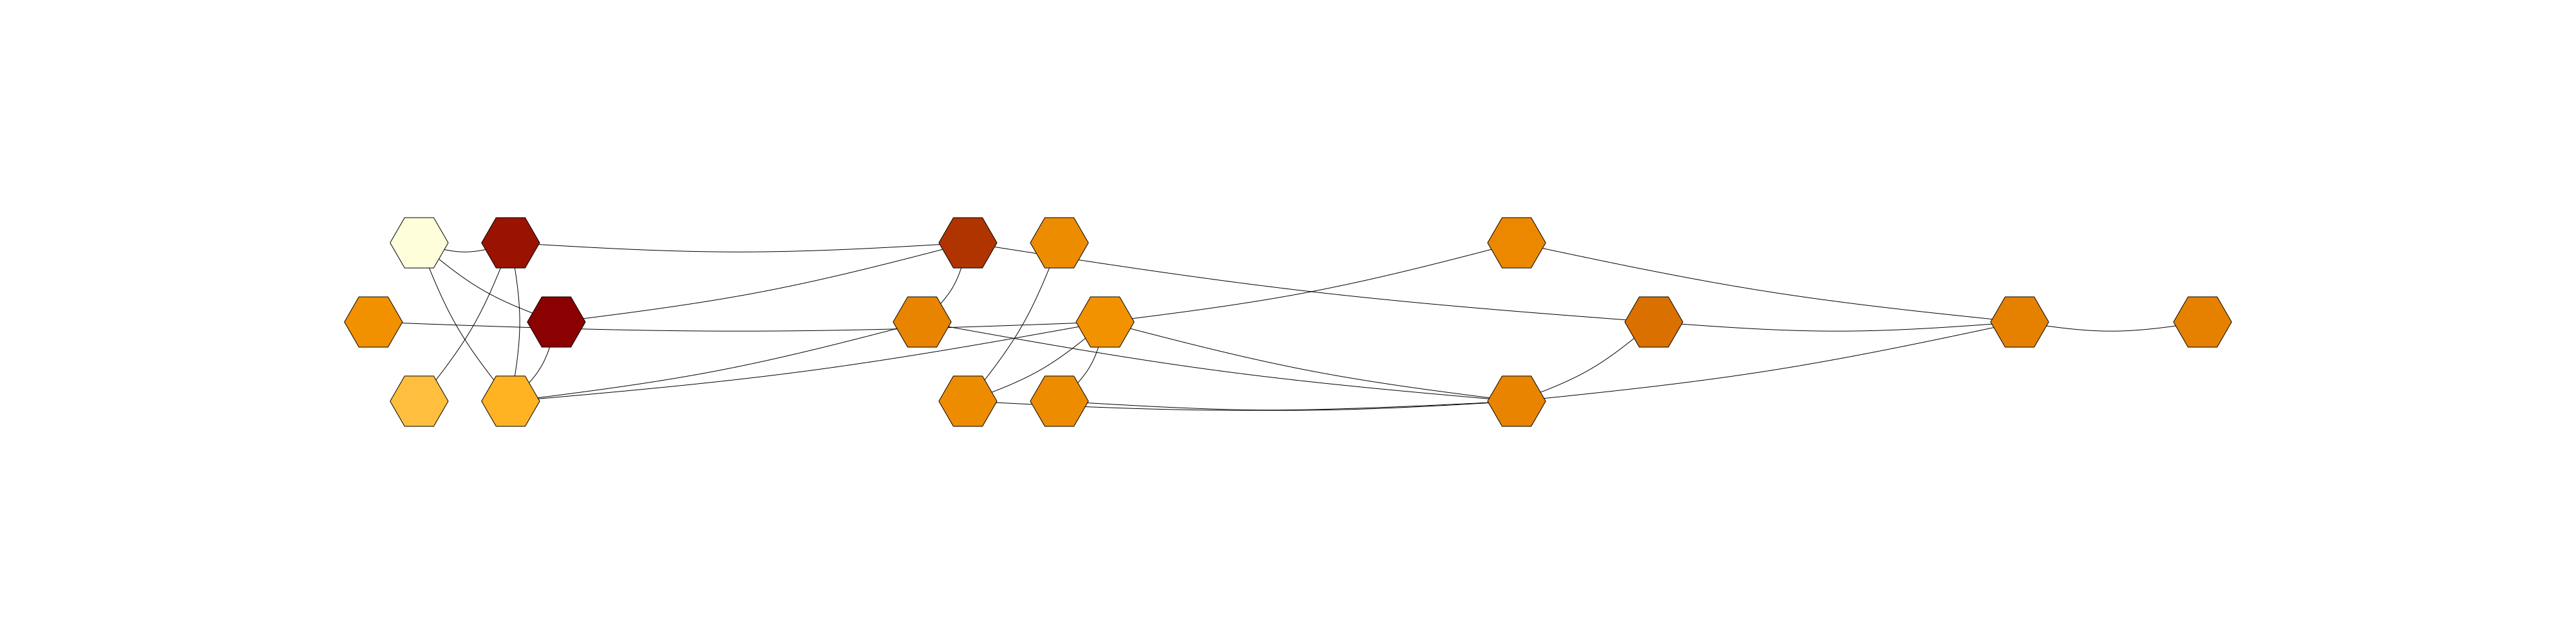

In [30]:
#Exact solution computation 
function dirichlet_solution(gd; seed_nu = 5)
    Random.seed!(seed_nu)
    uB = rand(gd.nB) # boundary condition
    uI = - gd.Lap[gd.I,gd.I] \ (gd.Lap[gd.I, gd.B]*uB)
    u = zeros(gd.nV); u[gd.I] = uI; u[gd.B] = uB
    return u 
end 

u_exact = dirichlet_solution(graph_data)

#Random walk solution 
Nrel = 100000
u_RW = RWC.RW_dirichlet(graph_data,u_exact,Nrel) #Only the boundary data from u_exact is used, but we pass the whole vector for conveience  

#Compare solutions 
println("relative error = ",100*norm(u_exact-u_RW)/norm(u_exact)," %")

#Plot exact solution 
RWC.plot_graph_func(graph_data,u_exact,save="yes",filename="fig2.png",labels="no")

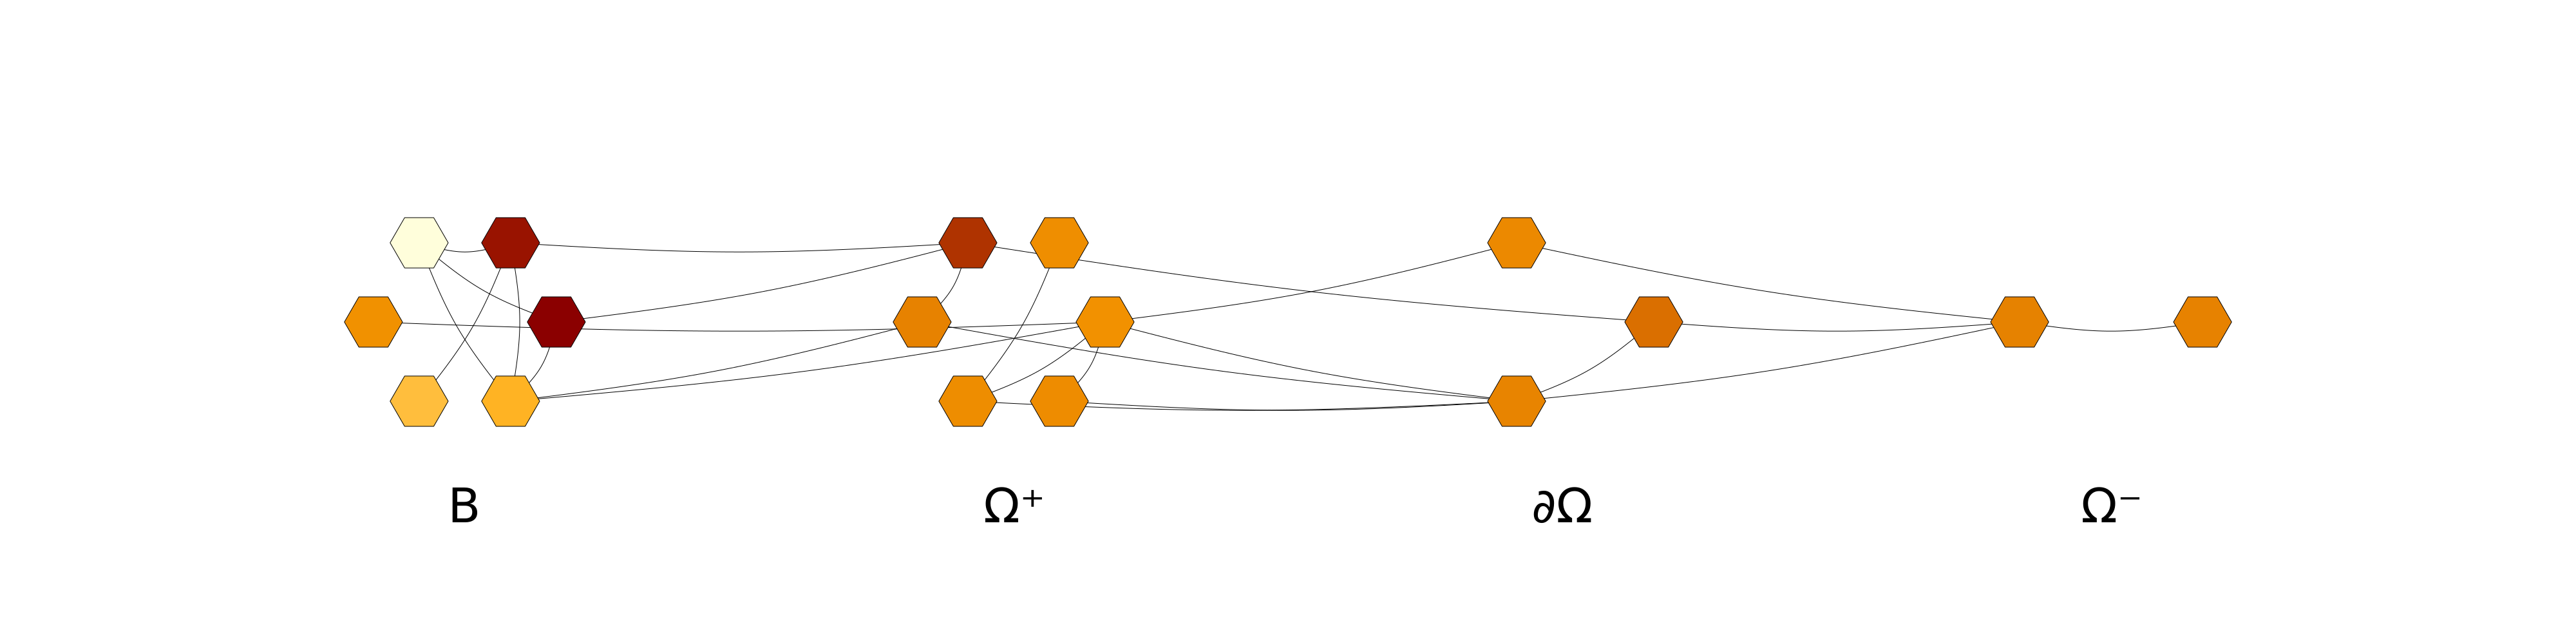

In [31]:
#Plot RW solution
RWC.plot_graph_func(graph_data,u_RW,save="yes",filename="fig3.png")

## Cloaking 

We consider two approaches to cloaking for random walks on graphs. We consider a region to be cloaked in the interior of our graph $\Omega^-$ with a boundary $\partial \Omega$. The region $\partial \Omega$ is a boundary in the sense that nodes in $\Omega$ are not connected to any nodes in $B$ or $\Omega^+$. We consider cloaking from two perspectives: one using the Dirichlet-to-Neumann map and one using a discrete potential theory. 

Both cloaking problems can be thought of in terms of being able to "control" some interior nodes including $\partial \Omega$. Via controlling these nodes we generate a new solution $u_{d}(x)$ such that
$$ u_{d}(x) = \begin{cases} 0 & x \in \Omega \\
                        u(x) & x \in B \cup \Omega^+.
            \end{cases}
                        $$

In the lattice example section, we present a similar problem for cloaking sources.


### Cloaking via the Dirichlet-to-Neumann map

The first approach to cloaking we consider for random walks is where the "control" is dictated by the Dirichlet-to-Neumann map. This control can be thought of any two ways: (1) we are allowed to end random walks when they reach $B$, and the start a random walk anywhere else on $B$ or (2) we are allowed to add edges making $\partial \Omega$ a completely connected graph while deleting all edges connected to $\Omega^-$. Thinking in therms of (2) the new edges should have conductivities that preserve the solution $u(x)$ on $B \cup \Omega^+$. We demonstrate how this would work on our previous example.

Relative reproduction error = 0.4523997725302253 %
Interior solution: [0.0, 0.0]


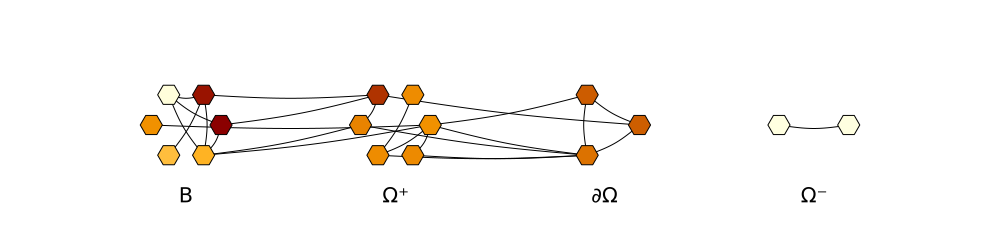

In [32]:
u_DTN = RWC.perfectcloak(graph_data,Nrel,u_exact) #Calculate DTN Solution

EN = setdiff(graph_data.V, graph_data.Ω ∪ graph_data.∂Ω) #Find set to calculate errors on 
println("Relative reproduction error = ",100*norm(u_exact[EN]-u_RW[EN])/norm(u_exact[EN])," %")
println("Interior solution: ", u_DTN[graph_data.Ω]) #Should be zero 

RWC.plot_graph_func(graph_data,u_DTN; DTN_graph = "yes")

### Cloaking via potential theory 

For every realization of random walks starting on the boundary we start random walks on a set of nodes including $\partial \Omega$ with charges that are to be determined. These charges should off-set the expected charge entering $\Omega^+$ while not adding to the net expected charge on $B \cup \Omega^-$. 

The charges, as well as the "control nodes", can be determined via potential theory. 

#### Deterministic reproductions 

We first consider the problem of deterministically reproducing a harmonic solution in a given domain while having a zero solution elsewhere by imposing a given voltage on a set of nodes. We call this set of control nodes with newly applied voltage $A$.

In order to define the single and double-layer potentials we choose an edge partition of the unity of the form $p^-|_{\mathcal{E}^{\partial\Omega}}=\alpha$ and $p^+|_{\mathcal{E}^{\partial\Omega}}=1-\alpha$ for $\alpha \in [0,1]$. The exterior $L^+$ and interior $L^-$ Laplacians should satisfy $L=L^+ + L^-$.

The discrete trace operators are the Dirichlet trace operator $\gamma_0 = R_{\partial \Omega}$ and the Neumann trace operators $\gamma_1^{\pm}= \mp R_{\partial \Omega} L_{\alpha}^{\pm}$. Here $R_{\partial \Omega}$ is the linear restriction operator for node valued functions (e.g. if $X$ is a node set and $u$ is a node function then $R_Xu = u|_X$). We define the single and double layer potentials
$$
\begin{split}
    \mathcal{S} &= G\gamma_0^T \\
    \mathcal{D^\pm} &=G (\gamma_1^{\pm})^T,
\end{split}
$$
where $G$ is the graph Green function. The $\pm$ reprsentations come from thinking about the net current into (resp. out of) a node. In the continuum this is analagous to fixing a convention for outward or inward normal vectors, however, unlike the continuum the choice is more than a matter of convention. Ultimately, it will result in different sets being used to realize dipoles. In both cases $\partial \Omega$ is used, in the minus case additional nodes are in $\Omega^-$ and in the plus case additional nodes are in $\Omega^+$. 

Given a function $u$ that is harmonic on $\partial \Omega \cup \Omega^-$ we get the following interior reproduction formulas 
$$
\mathcal{S}(\gamma_1^\pm u) - \mathcal{D}^{\pm}(\gamma_0 u) = \begin{cases} u(x) & x \in \Omega^- \\
0 & x \in \Omega^+ \cup B.
\end{cases}
$$
Given a function $v$ that is harmonic on $I \cup \partial \Omega$ and is zero on $B$ we get the following exterior reproduction formulas
$$
-\mathcal{S}(\gamma_1^\pm v) + \mathcal{D}^{\pm}(\gamma_0 v) = \begin{cases} 0 & x \in \Omega^- \\
v(x) & x \in I \cup \Omega^+.
\end{cases}
$$
These results are more carefully stated in the paper and consider the values on $\partial \Omega$ as well as more general restrictions on $u$ and $v$. 

Below we demonstrate an example of using the interior reproduction formulas to achieve cloaking, first showing what nodes are used to realize the cloak in both the plus and minus set. We differentiate between the two sets as $A^\pm$. 

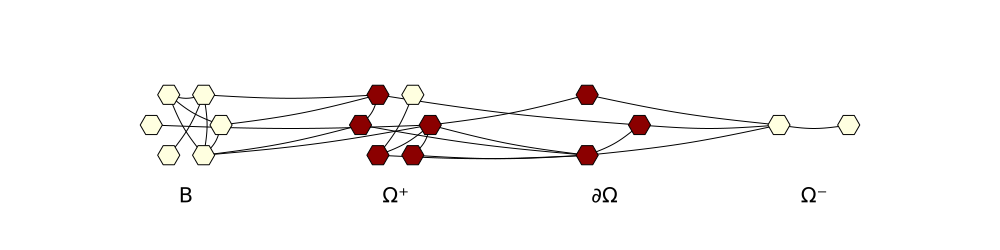

In [33]:
plus_set, minus_set = RWC.calc_sets(graph_data)
#Nodes that are controlled are in red 
RWC.plot_graph_func(graph_data,plus_set)

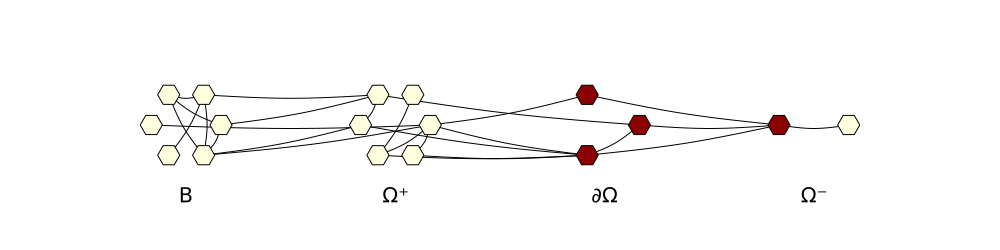

In [34]:
#Nodes that are controlled are in red 
RWC.plot_graph_func(graph_data,minus_set)

We then can achieve the desired effect of canceling the field inside $\Omega^-$. 

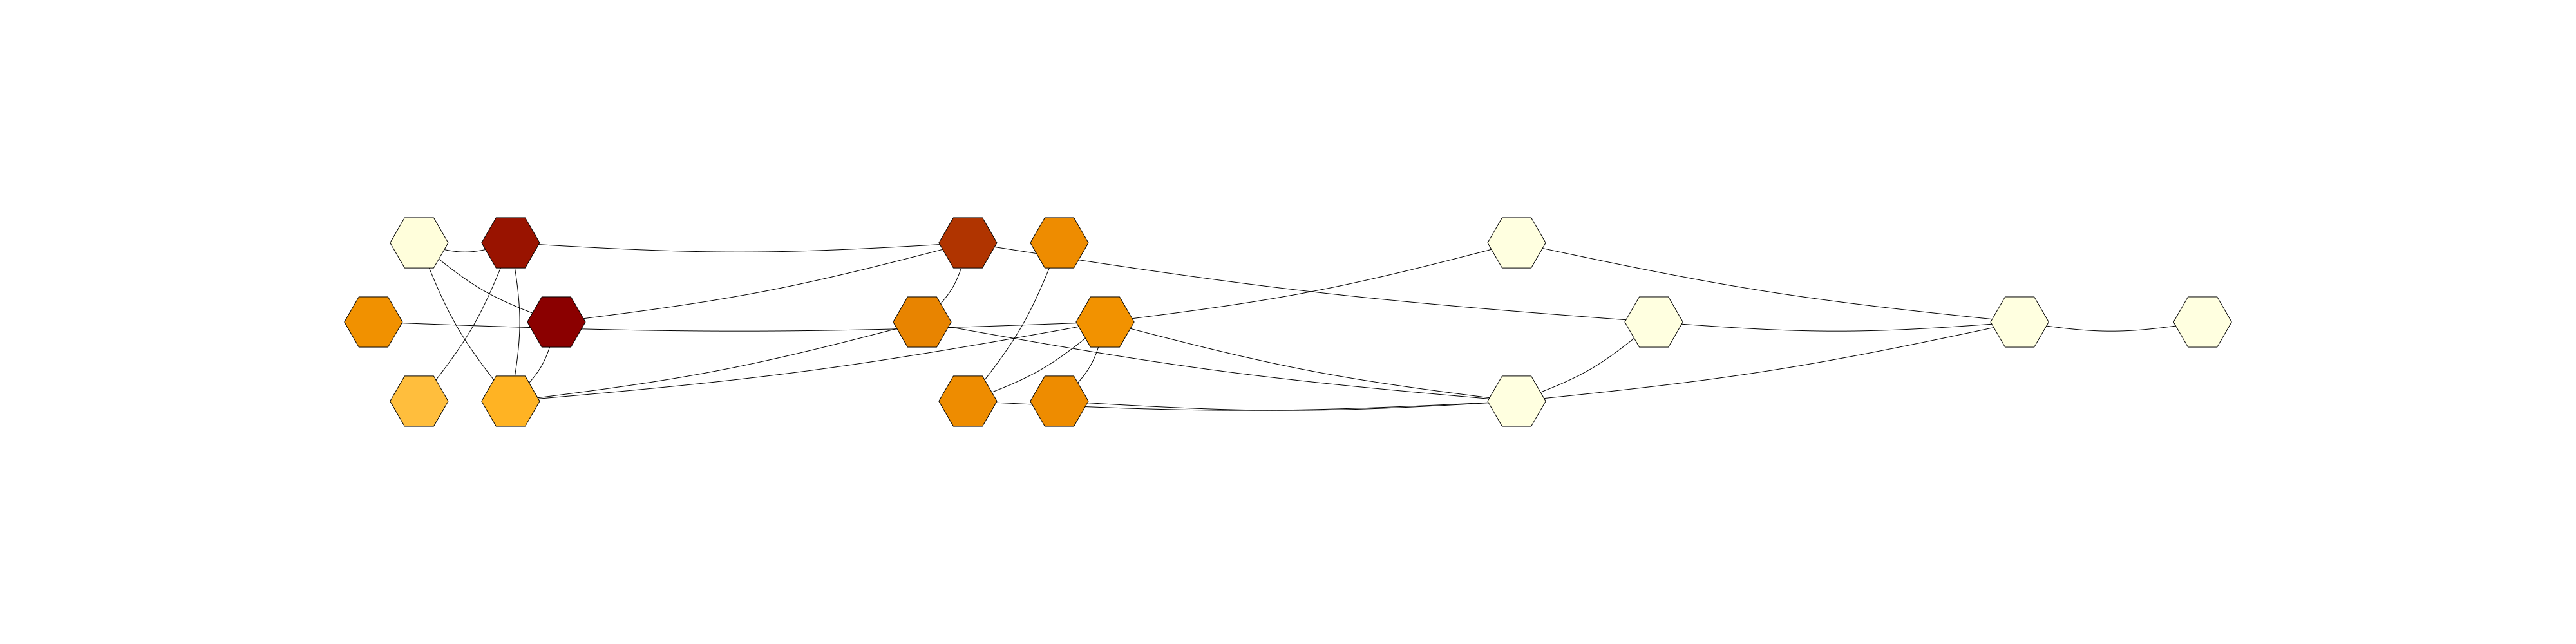

In [37]:
#Deterministic reproductions 
ps = setdiff(graph_data.V,graph_data.Ω); ms = graph_data.∂Ω ∪ graph_data.Ω; bs= graph_data.∂Ω
SLP_plus = RWC.SLP(ps,bs,graph_data)
DLP_plus = RWC.DLP(ps ,bs,graph_data)
SLP_minus = RWC.SLP(ms, bs ,graph_data)
DLP_minus = RWC.DLP(ms ,bs ,graph_data)
u_rec_plus = ((SLP_plus-DLP_plus)*u_exact)
u_rec_minus = ((-SLP_minus+DLP_minus)*u_exact)

#Plus recreation 
RWC.plot_graph_func(graph_data,u_exact-u_rec_plus,save="yes",filename="fig7.png",labels="no")

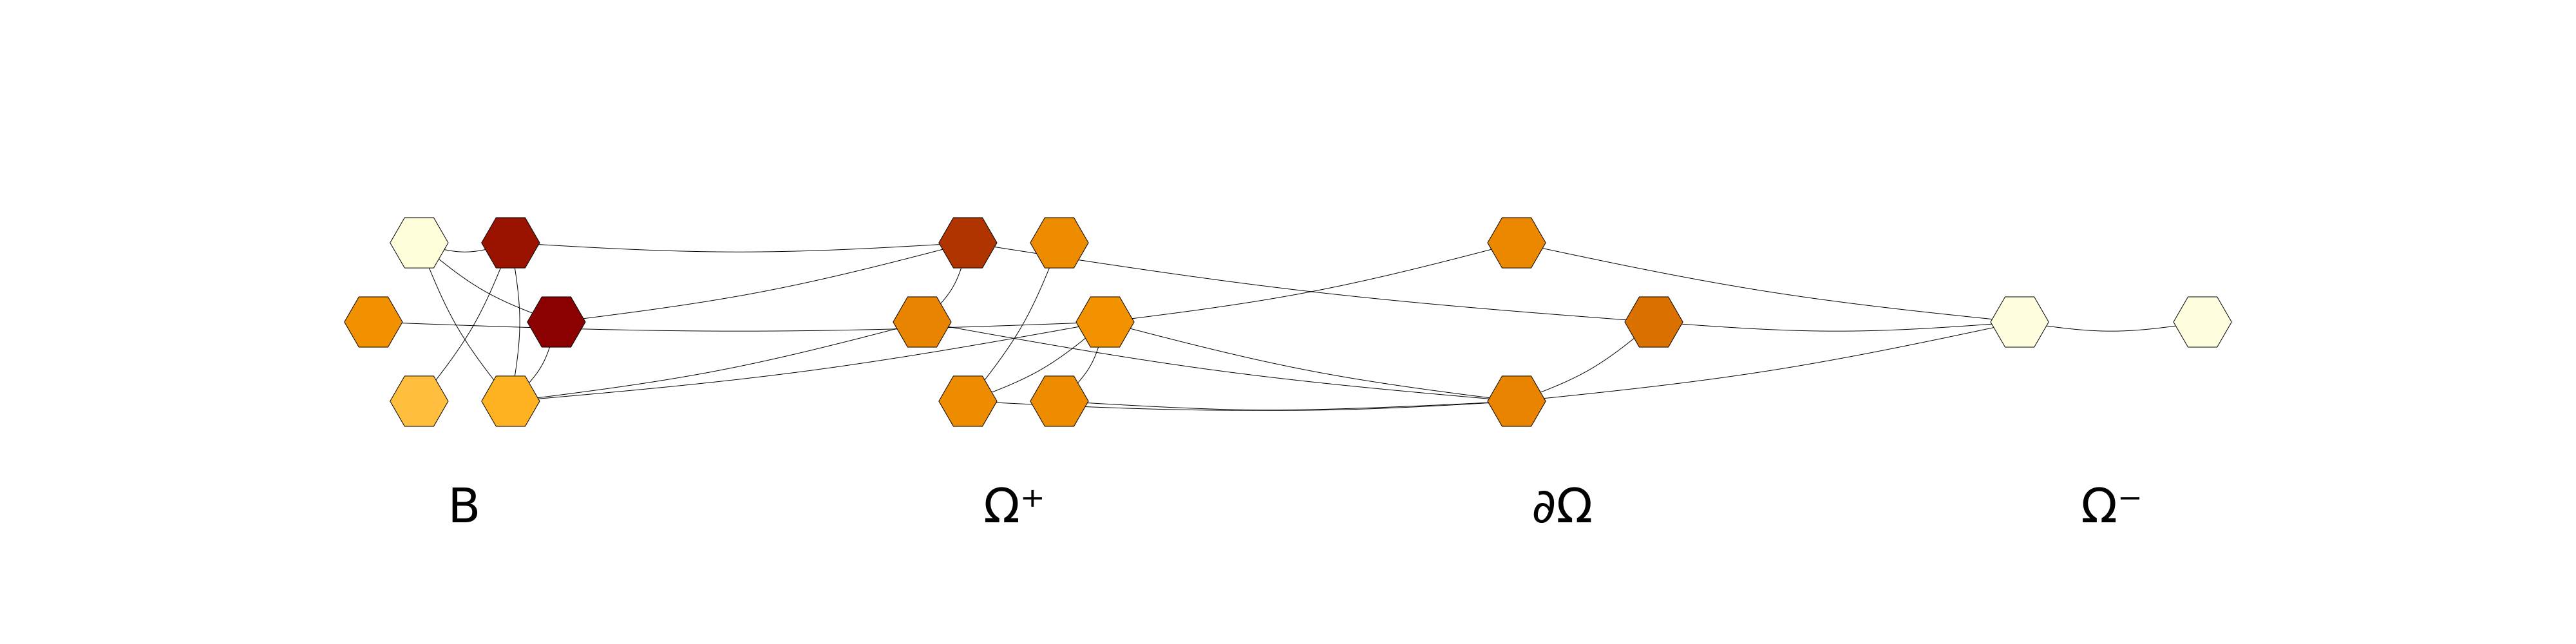

In [38]:
#Minus recreation
RWC.plot_graph_func(graph_data,u_exact-u_rec_minus,save="yes",filename="fig8.png")

#### Stochastic cloaking

We note that the Green function matrix $G$ can be factored out of the interior representation formulas $G( \pm RR^TL_\alpha^\pm \mp L_\alpha^\pm RR^T)$. Then, the remaining vector $( \pm RR^TL^\pm_\alpha \mp L^\pm_\alpha RR^T)u$ gives exactly the charges that are needed for the random walk cloaking. To be precise, we: 

(1) Calculate $ - (\pm RR^TL^\pm_\alpha \mp L^\pm_\alpha RR^T)u$. 

(2) The location of the non-zero entries corresponds to the boundary $\partial \Omega$ as well as the
additional nodes that need to be controlled to achieve dipoles (i.e. $A^\pm$). We will call these non-zero entries $\phi^\pm$. 

(3) Start a random walk from each of these nodes $x$ with charge $\phi^\pm(x)$ at every realization in addition to the random walks started on $B$.

(4) Average over the number of realizations.

We note that the minus sign in step (1) is so that the field is canceled inside $\Omega$. 

Below we calculate the stochastic cloak using $N_{rel}$ realizations. We also display the error relative to the deterministic cloaking solution.

relative error = 2.032802152836954 %


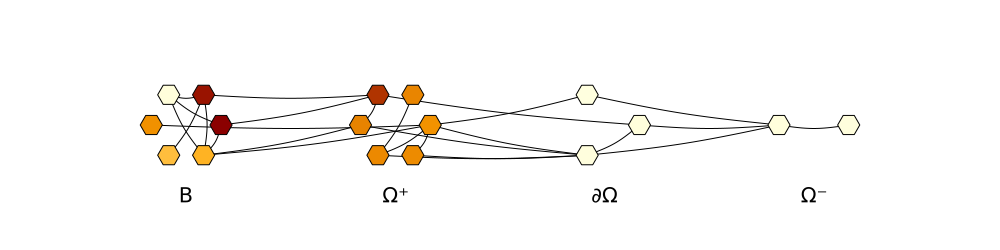

In [25]:
wm = (-RWC.SLP_noG(ms,bs,graph_data)+RWC.DLP_noG(ms,bs,graph_data))*u_exact
wp = (RWC.SLP_noG(ps,bs, graph_data)-RWC.DLP_noG(ps,bs, graph_data))*u_exact

u_stochastic_plus = RWC.stochastic_rep(graph_data,Nrel,wp)
u_stochastic_minus = RWC.stochastic_rep(graph_data,Nrel,wm)


println("relative error = ",100*norm(u_rec_plus-u_stochastic_plus)/norm(u_rec_plus)," %")
#Plus recreation 
RWC.plot_graph_func(graph_data,u_exact-u_stochastic_plus)

relative error = 1.5987245409360709 %


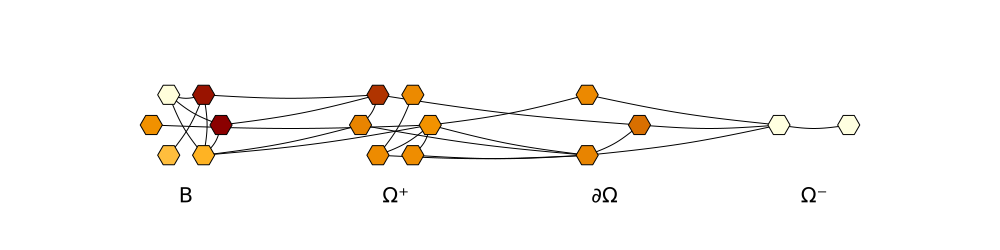

In [26]:
println("relative error = ",100*norm(u_rec_minus-u_stochastic_minus)/norm(u_rec_minus)," %")
#Plus recreation 
RWC.plot_graph_func(graph_data,u_exact-u_stochastic_minus)

## Examples on a Lattice 

Now we consider the same problems on a lattice with a defect. 

### Node with Dirichlet condition

We assume that inside $\Omega$ is a node with a zero Dirichlet condition. The defect is at a node that is in $\Omega$ but not in $A^-$ so we can use both interior reproduction formulas to achieve cloaking.

In [39]:
#Sample solution 
lat_data = RWC.gen_lattice()
Random.seed!(20)
uB = ones(lat_data.nB) # boundary condition
uB[1:11] .= 0
#[uB[i:(i+1)] = 1 .+ uB[(i-2):(i-1)] for i ∈ 12:2:28]
#uB[30:end] .= 10
uB[30:end] .=2
uI = - lat_data.Lap[lat_data.I,lat_data.I] \ (lat_data.Lap[lat_data.I,lat_data.B]*uB)
u = zeros(lat_data.nV); u[lat_data.I] = uI; u[lat_data.B] = uB

#Plot perfect lattice 
RWC.plot_lat_function(lat_data,u)

┌ Warning: attempting to remove probably stale pidfile
│   path = "/Users/fguevara/.jlassetregistry.lock"
└ @ Pidfile ~/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


data: [
  "scatter with fields line, mode, type, x, and y",
  "scatter with fields line, mode, type, x, and y",
  "scatter with fields marker, mode, text, type, x, and y"
]

layout: "layout with fields height, hovermode, margin, showarrow, showlegend, template, width, xaxis, and yaxis"

Now, we plot the field using the same boundary condition but with a defective node in the center. 

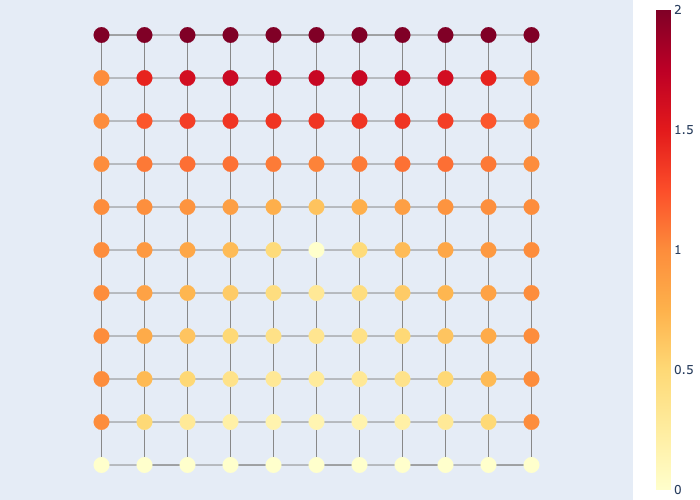

In [12]:
#Plot defective lattice 
defect_data = RWC.add_defect(lat_data,5*11+6)

uBd = vcat(uB,0) # boundary condition
uI = - defect_data.Lap[defect_data.I,defect_data.I] \ (defect_data.Lap[defect_data.I,defect_data.B]*uBd)
u_defect = zeros(defect_data.nV); u_defect[defect_data.I] = uI; u_defect[defect_data.B] = uBd

RWC.plot_lat_function(defect_data,u_defect)

Finally, we show that sets $B$, $I$, $\partial \Omega$ and $\Omega$ which are shaded from darkest to lighest respectively. 

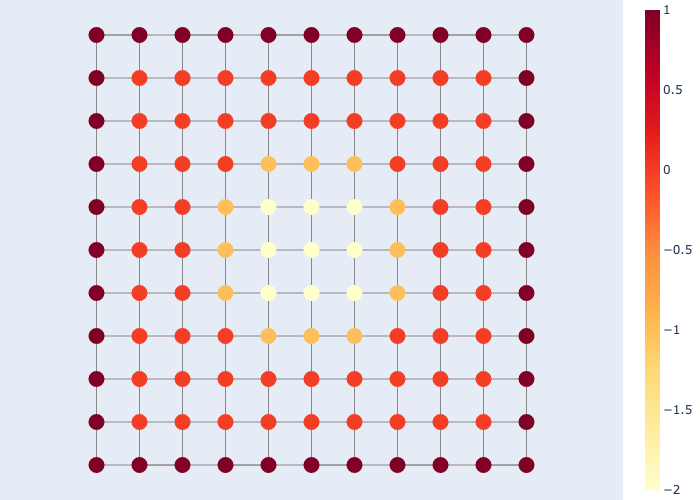

In [13]:
#∂Ω Indicator 
∂ΩI = zeros(lat_data.nV); ∂ΩI[lat_data.∂Ω] .=-1 
∂ΩI[lat_data.B] .=1
∂ΩI[lat_data.Ω] .= -2
RWC.plot_lat_function(lat_data,∂ΩI)

#### DTN cloak

We calculate the DTN cloak using Nrel realizations of random walks. In this representation, the edges between $\Omega$ and $\partial \Omega$ have been deleted although they still appear in the plot below. 

Relative reproduction error = 2.8174304575993303 %


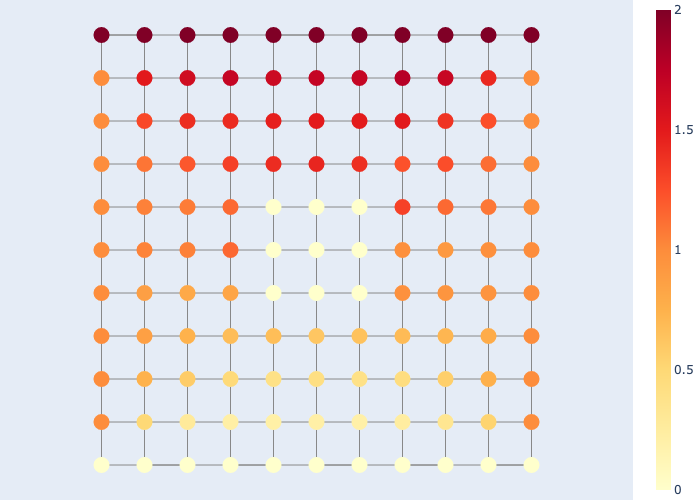

In [14]:
#DTN cloak
Nrel = 1000
u_DTN = RWC.perfectcloak(lat_data,Nrel,u)
EN = setdiff(lat_data.V, lat_data.Ω ∪ lat_data.∂Ω)
OU = lat_data.Ω
println("Relative reproduction error = ",100*norm(u[EN]-u_DTN[EN])/norm(u[EN])," %")

RWC.plot_lat_function(defect_data,u_DTN)

#### Potential theory cloak

For the potential theory cloak, we use the expectation of the field from the defective lattice and only calculate the RWs from the cloaking nodes.

First we show the $A^+$ control set

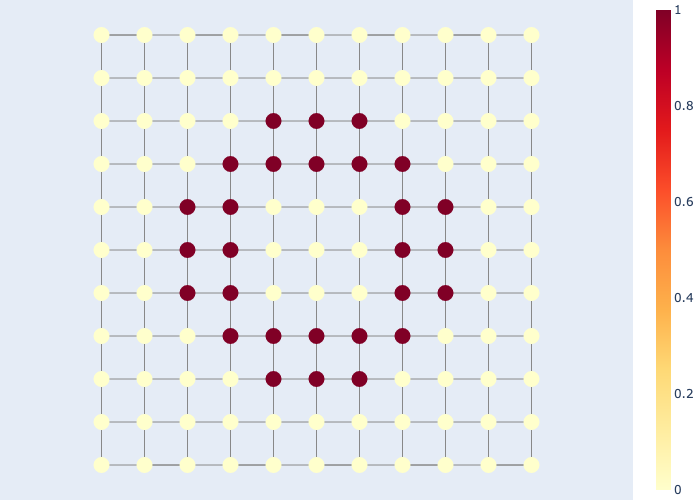

In [15]:
# Potential theory plus sets and minus sets

plus_set, minus_set = RWC.calc_sets(lat_data)

RWC.plot_lat_function(lat_data,plus_set)

Then the $A^-$ control set. 

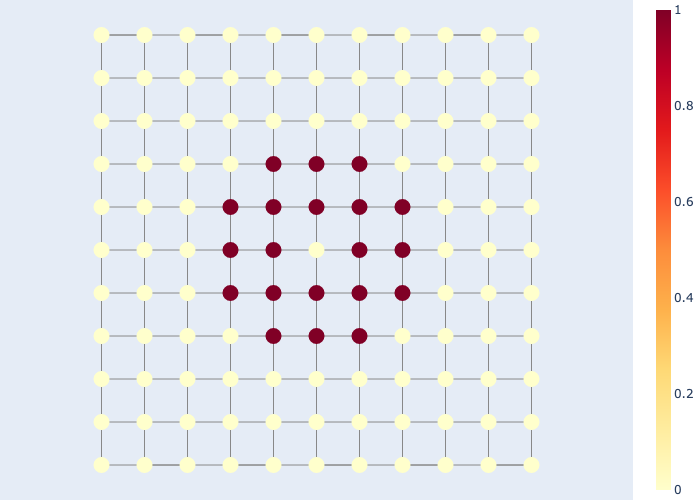

In [16]:
RWC.plot_lat_function(lat_data, minus_set)

Using both setups we demonstrate cloaking. Additionally, we state the relative errors from the deterministic potential theoretic cloak.

relative error = 0.3768860722147243 %


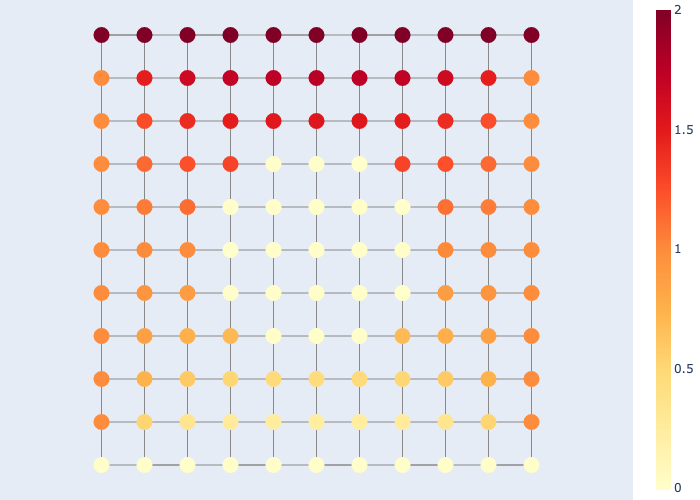

In [17]:
# Potential theory cloaking 
Random.seed!(3)
ps = setdiff(lat_data.V,lat_data.Ω); ms = lat_data.∂Ω ∪ lat_data.Ω; bs= lat_data.∂Ω
wm = (-RWC.SLP_noG(ms,bs,lat_data)+RWC.DLP_noG(ms,bs,lat_data))*u
wp = (RWC.SLP_noG(ps,bs,lat_data)-RWC.DLP_noG(ps,bs,lat_data))*u
Nrel = 100000
u_stochastic_plus = RWC.stochastic_rep(defect_data,Nrel,-wp)
u_stochastic_minus = RWC.stochastic_rep(defect_data,Nrel,-wm)

SLP_plus = RWC.SLP(ps,bs,lat_data)
DLP_plus = RWC.DLP(ps ,bs,lat_data)
u_rec_plus = ((SLP_plus-DLP_plus)*u)

#Plus reproduction
u_a = u-u_rec_plus
u_p = u_defect+u_stochastic_plus

println("relative error = ",100*norm(u_a-u_p)/norm(u_a)," %")

RWC.plot_lat_function(lat_data,u_p)

Relative reproduction error = 0.14188919477737705 %


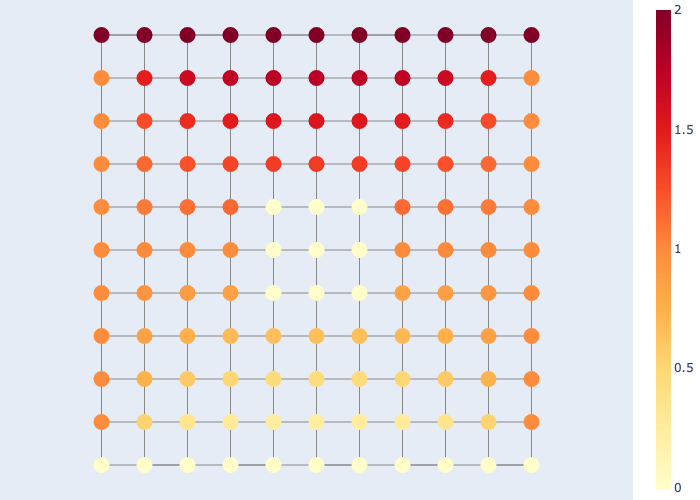

In [18]:
#Minus reproduction
u_m = u_defect+u_stochastic_minus
println("Relative reproduction error = ",100*norm(u[EN]-u_m[EN])/norm(u[EN])," %")
RWC.plot_lat_function(lat_data,u_m)

A final note to emphasize about the potential theory cloak is that *particles are entering the cloaking region.* This means the method is distinct from the DTN cloak which completely stops any random walker from entering $\Omega$. However, the expectation of the *net charges* of the random walkers is zero in the interior. To demonstrate this point we look at the net *absolute* charges from the plus configuration. We still use the expected value of the defective lattice field (the boundary values here are positive so this does not make a difference in this case). 

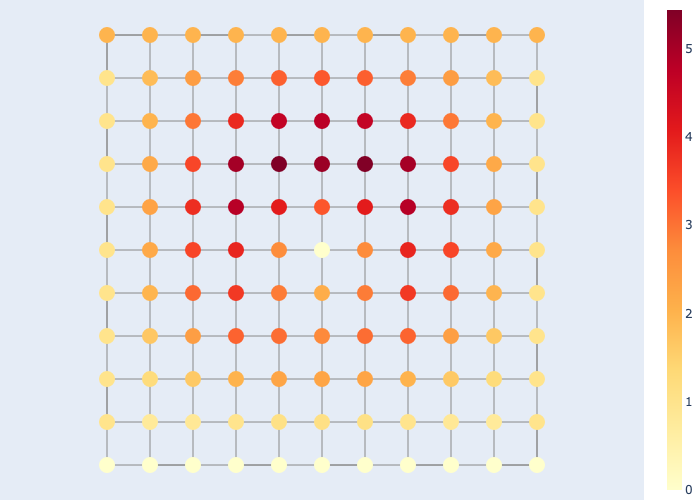

In [19]:
Random.seed!(3)
u_stochastic_plus_abs = RWC.stochastic_rep(defect_data,Nrel,abs.(wp))
RWC.plot_lat_function(lat_data,u_defect+u_stochastic_plus_abs)

### Source example on a lattice

Here, we demonstrate cloaking a source that is centered at the origin with homogenous Dirichlet boundary conditions.

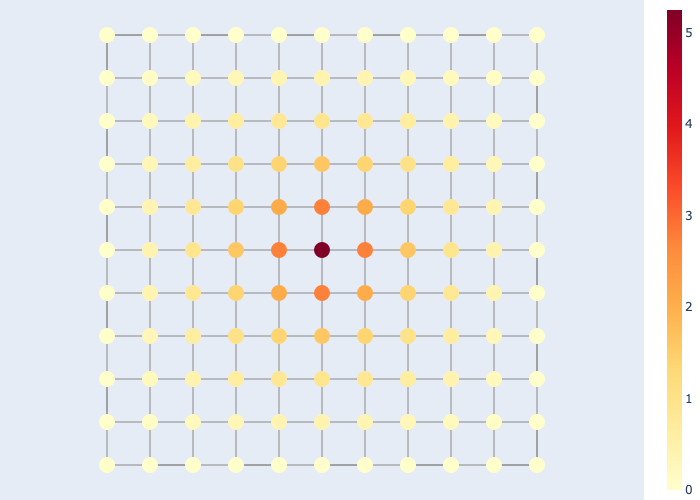

In [20]:
Random.seed!(123)
lat_data = RWC.gen_lattice()
uB = rand(lat_data.nB)*0 # boundary condition

u = 10*lat_data.G[5*11+6,:] 

#Plot perfect lattice 
RWC.plot_lat_function(lat_data,u)

Then, using the exterior reproduction formula for both the plus and minus sets we can demonstrate cloaking.

In [21]:
Random.seed!(101)
wm = (RWC.SLP_noG(ms,bs,lat_data)-RWC.DLP_noG(ms,bs,lat_data))*u
wp = (-RWC.SLP_noG(ps,bs,lat_data)+RWC.DLP_noG(ps,bs,lat_data))*u

Nrel = 100000
u_stochastic_plus = RWC.stochastic_rep(lat_data,Nrel,-wp)
u_stochastic_minus = RWC.stochastic_rep(lat_data,Nrel,-wm)
SLP_plus = RWC.SLP(ps,bs,lat_data)
DLP_plus = RWC.DLP(ps ,bs,lat_data)
SLP_minus = RWC.SLP(ms,bs,lat_data)
DLP_minus = RWC.DLP(ms ,bs,lat_data)
u_rec_plus = ((SLP_plus-DLP_plus)*u)
u_rec_minus = ((DLP_minus-SLP_minus)*u)

#Plus reproduction
u_a = u+u_rec_plus
u_p = u+u_stochastic_plus;

relative error = 0.46108139009162147 %


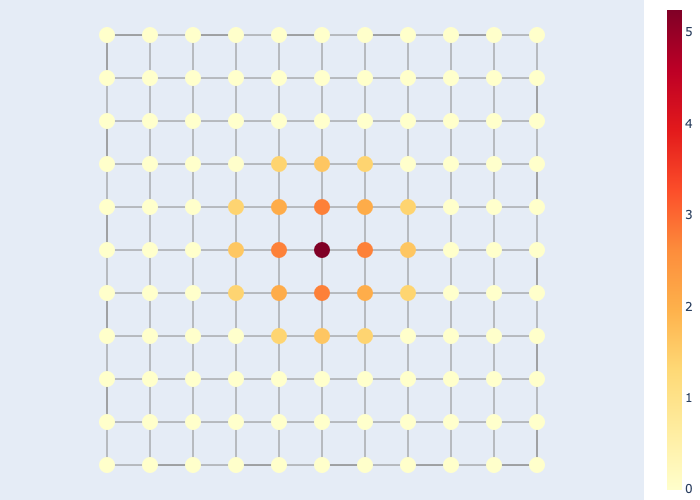

In [22]:
println("relative error = ",100*norm(u_a-u_p)/norm(u_a)," %")
RWC.plot_lat_function(lat_data,u_p)

relative error = 0.7262404342011594 %


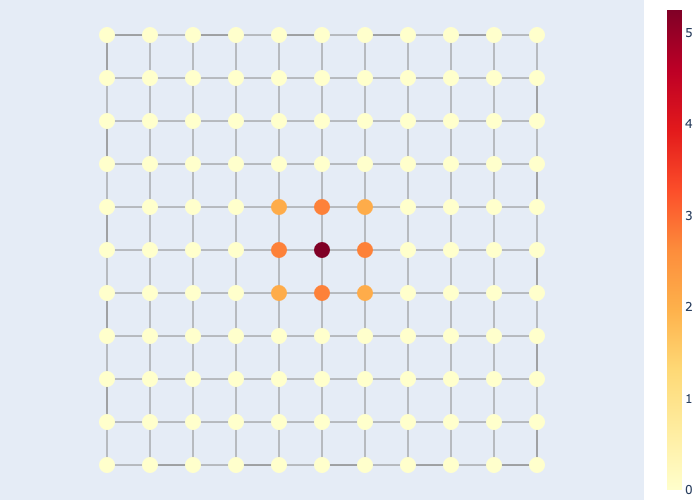

In [23]:
#Minus reproduction
u_a = u+u_rec_minus
u_p = u+u_stochastic_minus

println("relative error = ",100*norm(u_a-u_p)/norm(u_a)," %")
RWC.plot_lat_function(lat_data,u_a)